## Import Library & Check GPU

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Mounted at /content/drive
Device used: cuda
GPU Name: NVIDIA A100-SXM4-80GB


## Load Data & Clean Data

In [2]:
base_path = '/content/drive/MyDrive/Dataset_MLDL/'

print("Loading datasets from Google Drive...")

try:
    df = pd.read_csv(base_path + 'midterm-regresi-dataset.csv', header=None)
    print("Data is successfully load")
except FileNotFoundError:
    print("File not found! Please recheck the folder and file names in Google Drive.")

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# Handling Missing Values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

Loading datasets from Google Drive...
Data is successfully load


## Preprocessing & Splitting

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SCALING
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## DEEP LEARNING MODEL DNN

In [4]:
class SongYearPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SongYearPredictor, self).__init__()
        # Input Layer to Hidden Layer 1
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        # Hidden Layer 2
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        # Hidden Layer 3
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.relu3(self.layer3(x))
        x = self.output(x)
        return x

# Model Initialization
input_dim = X.shape[1]
model = SongYearPredictor(input_dim).to(device)

# Loss Function dan Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## TRAINING

Start Training...
Epoch [20/200], Loss (MSE): 75.9073
Epoch [40/200], Loss (MSE): 73.5215
Epoch [60/200], Loss (MSE): 72.5148
Epoch [80/200], Loss (MSE): 71.6486
Epoch [100/200], Loss (MSE): 71.4809
Epoch [120/200], Loss (MSE): 70.8689
Epoch [140/200], Loss (MSE): 70.7019
Epoch [160/200], Loss (MSE): 70.4869
Epoch [180/200], Loss (MSE): 69.9909
Epoch [200/200], Loss (MSE): 69.9086


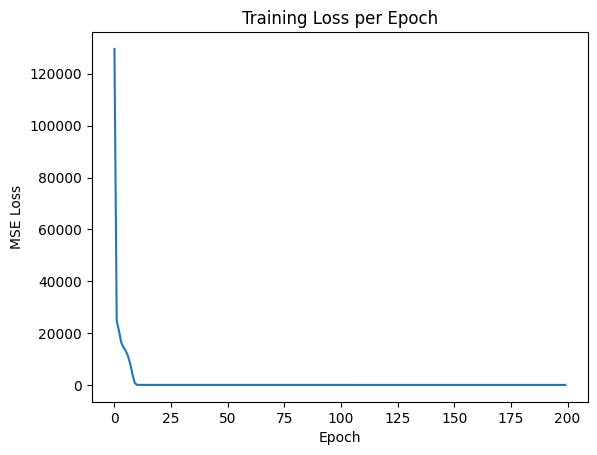

In [6]:
epochs = 200
loss_history = []

print("Start Training...")
model.train() # Set mode training
for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # 1. Reset gradien
        optimizer.zero_grad()
        # 2. Forward pass
        predictions = model(batch_X)
        # 3. Error calculation
        loss = criterion(predictions, batch_y)
        # 4. Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss per epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss (MSE): {avg_loss:.4f}')

# Plotting Loss
plt.plot(loss_history)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Model Evaluation

In [7]:
model.eval() # Set mode evaluastion
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("-" * 30)
print("Evaluation Result")
print("-" * 30)
print(f"MSE  (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} (Average missed {rmse:.2f} year)")
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"R² Score: {r2:.4f} (The closer it is to 1.0, the better.)")

------------------------------
Evaluation Result
------------------------------
MSE  (Mean Squared Error): 75.79
RMSE (Root Mean Squared Error): 8.71 (Average missed 8.71 year)
MAE  (Mean Absolute Error): 6.07
R² Score: 0.3632 (The closer it is to 1.0, the better.)


# Executive Summary

The model successfully runs and converges, but it demonstrates **suboptimal predictive performance**. With an **R² score of 0.3632**, the model can only explain approximately **36% of the variance** in the dataset. The error margins (**RMSE ≈ 8.7 years**) indicate that while the model captures some general trends, it struggles to pinpoint the release year accurately, likely due to **underfitting**.

---

# Detailed Analysis

## 1. Training Behavior (Loss Convergence)

**Steady Descent**  
The training loss (MSE) decreased steadily from approximately **75.9 (Epoch 20)** to **69.9 (Epoch 200)**. This indicates that the optimization process (Adam optimizer) is functioning correctly and the model is learning from the input features.

**Plateauing**  
Towards the final epochs (**160–200**), the loss reduction slowed significantly, dropping **less than 0.6 points over 40 epochs**. This suggests that the model has reached a performance plateau and is unlikely to improve further with the current architecture or learning rate.

---

## 2. Evaluation Metrics on Test Data

### RMSE (Root Mean Squared Error): **8.71**

**Interpretation:**  
On average, the model's predictions deviate by approximately **8.7 years** from the actual release year. In the context of music history, this represents a substantial error margin (e.g., confusing songs from different musical eras such as 1981, 1990, and 1999).

---

### MAE (Mean Absolute Error): **6.07**

**Interpretation:**  
The average absolute difference between predicted and actual release year is around **6 years**. This value being lower than the RMSE suggests the presence of **outlier predictions** that disproportionately increase the RMSE.

---

### R² Score: **0.3632**

**Interpretation:**  
The model explains only **36.3% of the variance** in the target variable. A well-performing regression model typically achieves an **R² above 0.7 or 0.8**, depending on data noise. This confirms that the current model and/or feature set is insufficient to fully capture the underlying patterns.

---

## 3. Diagnosis: Underfitting

**The Gap**  
The final training loss (**≈ 69.9**) and test loss (**≈ 75.8**) are relatively close.

**Conclusion**  
When both training and test errors are **high and similar**, it is a classic indicator of **underfitting (high bias)**. The model lacks sufficient complexity, or the input features do not provide enough predictive signal. Overfitting is minimal (dropout is effective), but the model fails to learn the data distribution adequately.

---

# Recommendations for Improvement

To improve the **R² score beyond 0.80** (as previously targeted), consider the following strategies:

- **Increase Model Complexity**  
  Add more hidden layers or increase the number of neurons (e.g., from **128 → 256 or 512**) to better capture complex relationships.

- **Feature Engineering**  
  Evaluate the correlation matrix and consider creating **non-linear feature combinations** or domain-specific features more strongly linked to the release year.

- **Adjust Learning Rate**  
  Since the loss has plateaued, try applying a **learning rate scheduler** or starting with a slightly higher learning rate to escape local minima.

- **Try Non-Deep Learning Models**  
  For tabular regression tasks, **tree-based models** such as **XGBoost, LightGBM, or Random Forest** often outperform simple DNNs. These models handle feature interactions more effectively and may provide a stronger baseline R² score.
